In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage.io as io
import imageio
import cv2

from pdb import set_trace
from pathlib import Path

[32.0, 16.0, 8.0, 4.0, 2.0, 1.0, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125, 0.00390625, 0.001953125, 0.0009765625]


(<Figure size 1300x500 with 16 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
       dtype=object))

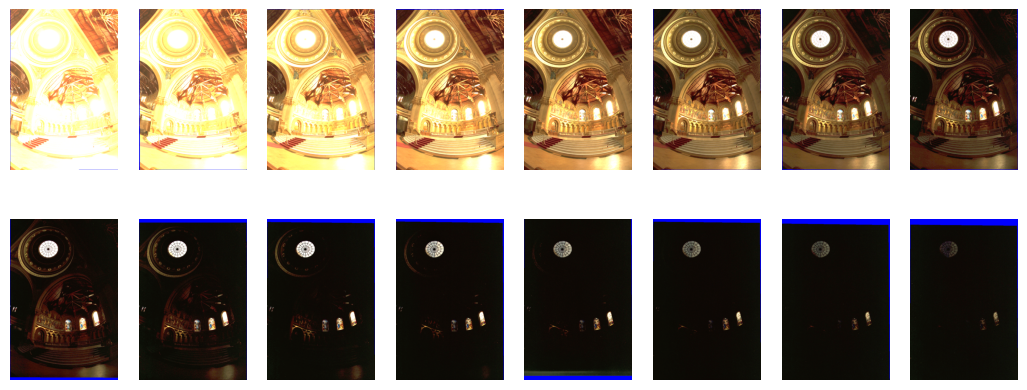

In [2]:
hdr_dir = 'hdr_data'

def read_exposures():
    filepaths = []
    exposures = []
    with open(Path(hdr_dir, 'memorial.hdr_image_list.txt')) as f:
        lines = f.readlines()
    for l in lines[3:]:
        data = l.split(' ')
        img_png = data[0].replace('.ppm', '.png')
        expo = 1/float(data[1]) #read value is 1/shutter speed, so inverse
        filepaths.append(Path(hdr_dir, img_png))
        exposures.append(expo)
    return filepaths, exposures

filepaths, exposures = read_exposures()
print(exposures)

def read_img(filepath):
    img = io.imread(filepath).astype(float)/255
    return img

def plot_images(imgs):
    fig, axes = plt.subplots(2, 8, figsize=(13, 5))
    ax = axes.ravel()
    for i in range(len(imgs)):
        ax[i].imshow(imgs[i])
        ax[i].axis('off')
    return fig, axes

imgs = [read_img(fp) for fp in filepaths]
# imgs[0].shape
plot_images(imgs)

(<Figure size 1300x500 with 16 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
       dtype=object))

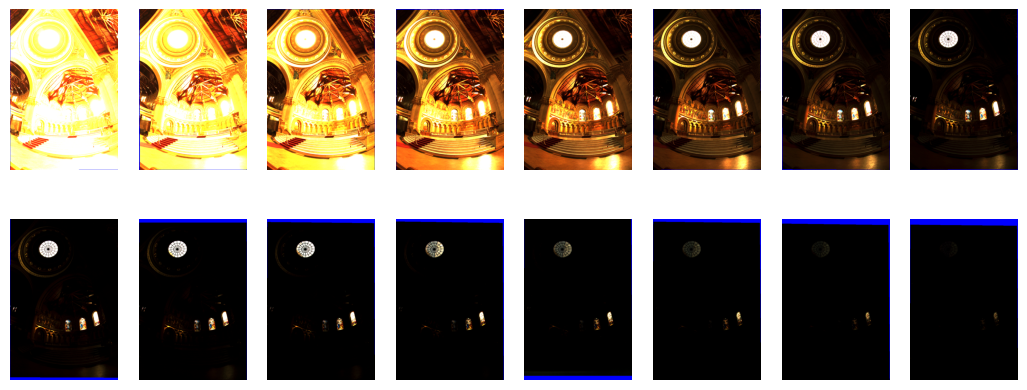

In [3]:
def linearize_img(img, gamma=2.2):
    return np.power(img, 2.2)

lin_imgs = list(map(lambda x: linearize_img(x, 2.2), imgs))
plot_images(lin_imgs)

(<Figure size 1300x500 with 16 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
       dtype=object))

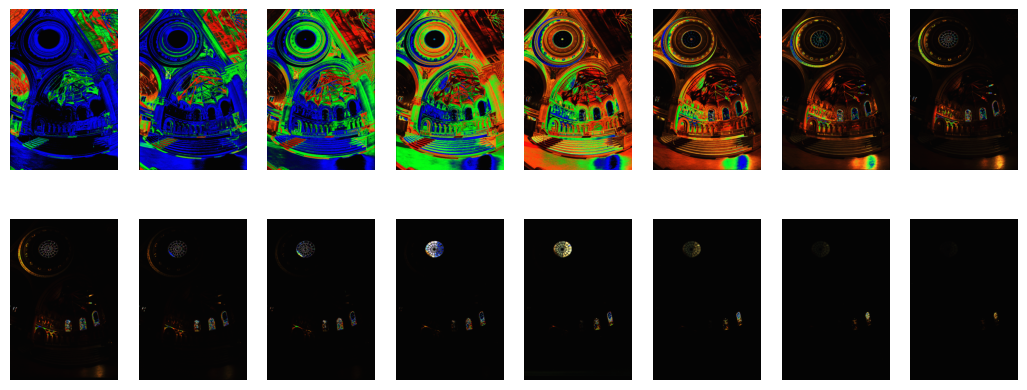

In [4]:
def compute_hdr_weights(img):
    center_dr = 0.5 # center of dynamic range between float[0, 1]
#     w = np.zeros_like(img)
#     for i in range(3):
#         img_i = img[:, :, i]
#         w[:, :, i] = np.exp(-4*np.square((img_i - center_dr)/center_dr))      
    w = np.exp(-4*np.square((img - center_dr)/center_dr))
    return w


# hdr_debevec(lin_imgs, exposures)

weight_maps = list(map(compute_hdr_weights, lin_imgs))
plot_images(weight_maps)

[-0.12349241 -1.54924409 -0.35715922]
[-0.46626977 -1.89202145 -0.40794085]
[-1.93429584 -2.23487491 -0.57130003]
[-2.25168229 -2.55226135 -0.59669085]
[-2.42522836 -2.66640237 -0.71171726]
[-2.71722389 -2.95839789 -0.71171726]
[-2.81255487 -3.05226583 -0.83104518]
[-2.91221209 -3.15515224 -0.96444588]
[-3.16612124 -3.40906139 -0.92635965]
[-3.40733494 -3.65027509 -0.87557801]
[-3.63585318 -3.87879333 -0.81210096]
[-3.85167596 -4.09461611 -0.7359285 ]
[-3.88662504 -4.13301031 -0.80567383]
[-4.0770569  -4.32344218 -0.70411056]
[-4.25479331 -4.50117859 -0.58985187]
[-4.41983426 -4.66621954 -0.46289778]


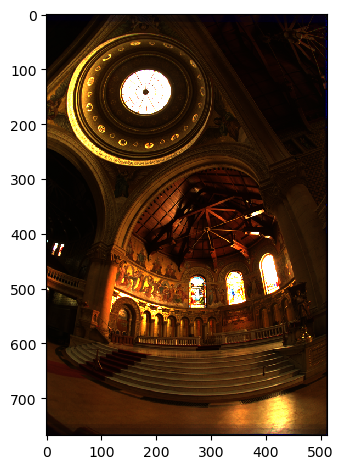

In [5]:
def crop_boundary(img):
    # crop boundary - image data here are only captured in some of the exposures, which is why they are indicated in blue in the LDR images
    return img[29:720, 19:480, :]

# approximate true HDR image X
def hdr_debevec(imgs, exposures):
    # initialize HDR image with all zeros
    hdr = np.zeros((768, 512, 3), dtype=float)
    # fuse LDR images using weights, make sure to store your fused HDR using the name hdr
    weights = []
    for k in range(len(imgs)):
        # add machine precision to avoid log(0)
        img_k = imgs[k] + np.finfo(np.float32).eps
        t_k = exposures[k]
        # compute weights
        w_k = compute_hdr_weights(img_k)
        weights.append(w_k)
        # compute and accumulate sum
        x_k = np.zeros_like(hdr)
#         for i in range(3):
#             x_k[:,:,i] = np.multiply(w_k[:,:,i], (np.log(img_k[:,:,i]) - np.log(t_k)))
        x_k = w_k * (np.log(img_k) - np.log(t_k))
        hdr += x_k
        print(hdr[1, 1, :])
        
    scale = np.sum(weights, axis=0) # weight scale
    hdr = np.exp(hdr/scale)
    
    # crop and clip
#     hdr = crop_boundary(hdr)
    hdr = np.clip(hdr, 0, 1)
    
    return hdr

hdr_lin_img = hdr_debevec(lin_imgs, exposures)
test = hdr_lin_img
# test = np.uint8( np.clip(3*test, 0, 1) *255)
# test[:, :, 1] = 0
# test[:, :, 0] = 0
io.imshow(test)

# np.max(hdr_lin_img)


['s=0.1, g=0.20', 's=0.1, g=0.33', 's=0.1, g=0.45', 's=1.0, g=0.20', 's=1.0, g=0.33', 's=1.0, g=0.45']


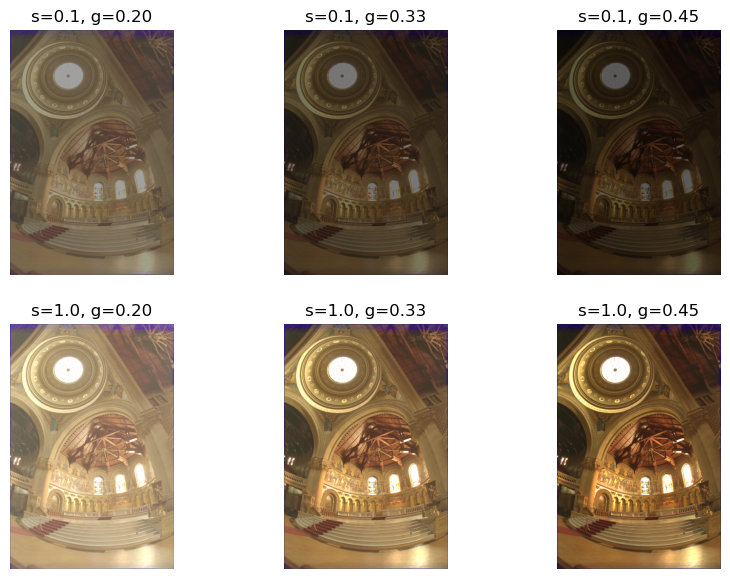

In [12]:
def clip_img(img):
    return np.clip(img, 0, 1)

def tonemap_linear(img):
    toned_img = np.zeros_like(img)
    for i in range(3):
        img_channel = img[:, :, i]
        max_value = np.max(img_channel)
        toned_img[:,:,i] = img_channel/max_value
    return toned_img 
    
def tonemap_scale_gamma(scale, gamma, img):
    toned_img = np.power(scale*img, gamma)
    return toned_img

def tonemap_photograph(hdr):
    img = np.divide(hdr, 1+hdr)
    return img

fig, axes = plt.subplots(2, 3, figsize=(10, 7))
ax = axes.ravel()
sg_hdr_imgs = {}
for s in [0.1, 1.0]:
    for g in [1/5, 1/3, 1/2.2]:
        sg_hdr_imgs[f's={s}, g={"{:.2f}".format(g)}'] = tonemap_scale_gamma(s, g, hdr_lin_img)
    
sg = list(sg_hdr_imgs.keys())
print(sg)
for i in range(len(sg)):
    key = sg[i]
    sg_img = sg_hdr_imgs[key]
    ax[i].axis('off')
    ax[i].set_title(key)
    ax[i].imshow(sg_img)
    


In [18]:
def tonemap_drago(hdr):
    hdr *= 0.8371896/np.mean(hdr)  # this makes the mean of the created HDR image match the reference image (totally optional)

    # convert to 32 bit floating point format, required for OpenCV
    hdr = np.float32(hdr)

    # tonemap image and save LDR image using OpenCV's implementation of Drago's tonemapping operator
    gamma = 1.0
    saturation = 0.7
    bias = 0.85
    tonemapDrago = cv2.createTonemapDrago(gamma,saturation,bias)
    ldrDrago = tonemapDrago.process(hdr)
    io.imsave('my_hdr_image_tonemapped.jpg', np.uint8( np.clip(3*ldrDrago, 0, 1) *255))

    # write HDR image (can compare to hw4_1_memorial_church.hdr reference image in an external viewer)
    hdr = cv2.cvtColor(hdr, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite('my_hdr_image.hdr', hdr)
    
    return hdr


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'drago')

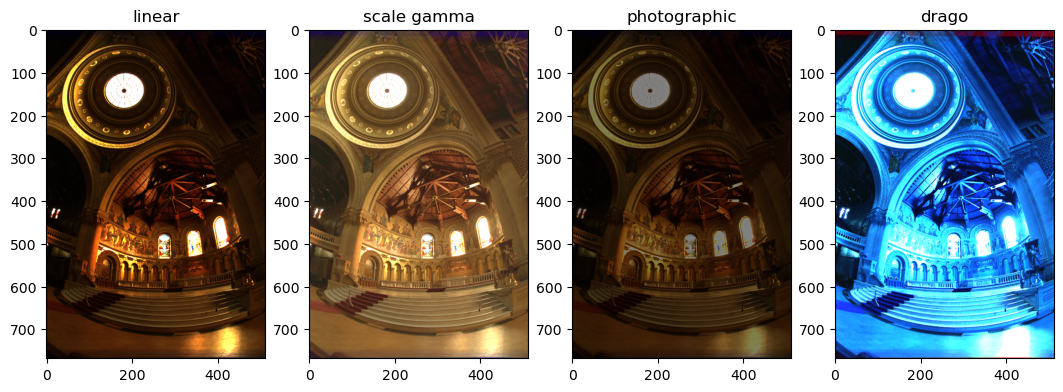

In [19]:
hdr_lin_clip = clip_img(hdr_lin_img)
fig, axes = plt.subplots(1, 4, figsize=(13, 5))
axes[0].imshow(tonemap_linear(hdr_lin_clip))
axes[0].set_title("linear")
axes[1].imshow(tonemap_scale_gamma(1, 1/2.2, hdr_lin_clip))
axes[1].set_title("scale gamma")
axes[2].imshow(tonemap_photograph(hdr_lin_clip))
axes[2].set_title("photographic")
axes[3].imshow(tonemap_drago(clip_img(hdr_lin_clip)))
axes[3].set_title("drago") # doesn't render in notebook well but .hdr file saves fine for viewing